# Lecture 12 - Decay into a squeezed vacuum field

Author: J. R. Johansson (robert@riken.jp), https://jrjohansson.github.io/

This lecture series was developed by J.R. Johansson. The original lecture notebooks are available [here](https://github.com/jrjohansson/qutip-lectures).

This is a slightly modified version of the lectures, to work with the current release of QuTiP. You can find these lectures as a part of the [qutip-tutorials repository](https://github.com/qutip/qutip-tutorials). This lecture and other tutorial notebooks are indexed at the [QuTiP Tutorial webpage](https://qutip.org/tutorials.html).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import (Bloch, about, basis, liouvillian, mesolve, n_thermal,
                   sigmam, sigmap, sigmax, sigmay, sigmaz, spost, spre)

%matplotlib inline

## Introduction

We follow *The theory of open quantum systems*, by Breuer and Pretruccione, section 3.4.3 - 3.4.4, which gives the master equation for a two-level system that decays into an environment that is in a squeezed vacuum state:

$\frac{d}{dt}\rho = \gamma_0(N+1)\left(\sigma_-\rho(t)\sigma_+ - \frac{1}{2}\sigma_+\sigma_-\rho(t) - \frac{1}{2}\rho(t)\sigma_+\sigma_-\right)$

$ + \gamma_0 N \left(\sigma_+\rho(t)\sigma_- - \frac{1}{2}\sigma_-\sigma_+\rho(t) - \frac{1}{2}\rho(t)\sigma_-\sigma_+\right)$

$ -\gamma_0 M \sigma_+\rho(t)\sigma_+ -\gamma_0 M^* \sigma_-\rho(t)\sigma_-$

where the parameters $N$ and $M$ describes the temperature and squeezing of the environmental modes:

$\displaystyle N = N_{\rm th} ({\cosh}^2 r + {\sinh}^2 r) + \sinh^2 r$

$\displaystyle M = - \cosh r \sinh r e^{i\theta} (2 N_{\rm th} + 1)$

Alternatively, this master equation can be written in standard Lindblad form,

$\frac{d}{dt}\rho = \gamma_0\left(C\rho(t)C^\dagger - \frac{1}{2}C^\dagger C\rho(t) - \frac{1}{2}\rho(t)C^\dagger C\right)$

where $C = \sigma_-\cosh r + \sigma_+ \sinh r e^{i\theta}$.

Below we will solve these master equations numerically using QuTiP, and visualize at the resulting dynamics.


### Problem parameters

In [2]:
w0 = 1.0 * 2 * np.pi
gamma0 = 0.05

In [3]:
# the temperature of the environment in frequency units
w_th = 0.0 * 2 * np.pi

In [4]:
# the number of average excitations in the
# environment mode w0 at temperature w_th
Nth = n_thermal(w0, w_th)

Nth

0.0

#### Parameters that describes the squeezing of the bath

In [5]:
# squeezing parameter for the environment
r = 1.0
theta = 0.1 * np.pi

In [6]:
N = Nth * (np.cosh(r) ** 2 + np.sinh(r) ** 2) + np.sinh(r) ** 2

N

np.float64(1.3810978455418155)

In [7]:
M = -np.cosh(r) * np.sinh(r) * np.exp(-1j * theta) * (2 * Nth + 1)

M

np.complex128(-1.7246746122879026+0.5603807511251908j)

In [8]:
# Check, should be zero according to Eq. 3.261 in Breuer and Petruccione
abs(M) ** 2 - (N * (N + 1) - Nth * (Nth + 1))

np.float64(0.0)

### Operators, Hamiltonian and initial state

In [9]:
sm = sigmam()
sp = sigmap()

In [10]:
H = (
    -0.5 * w0 * sigmaz()
)  # by adding the hamiltonian here, so we move back to the schrodinger picture

In [11]:
c_ops = [np.sqrt(gamma0 * (N + 1)) * sm, np.sqrt(gamma0 * N) * sp]

Let's first construct the standard part of the Liouvillian, corresponding the unitary contribution and the first two terms in the first master equation given above:

In [12]:
L0 = liouvillian(H, c_ops)

L0

Quantum object: dims=[[[2], [2]], [[2], [2]]], shape=(4, 4), type='super', dtype=CSR, isherm=False
Qobj data =
[[-0.11905489+0.j          0.        +0.j          0.        +0.j
   0.06905489+0.j        ]
 [ 0.        +0.j         -0.09405489-6.28318531j  0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j         -0.09405489+6.28318531j
   0.        +0.j        ]
 [ 0.11905489+0.j          0.        +0.j          0.        +0.j
  -0.06905489+0.j        ]]

Next we manually construct the Liouvillian for the effect of the squeeing in the environment, which is not on standard form we can therefore not use the `liouvillian` function in QuTiP

In [13]:
Lsq = -gamma0 * M * spre(sp) * spost(sp) - gamma0 * \
      M.conj() * spre(sm) * spost(sm)

Lsq

Quantum object: dims=[[[2], [2]], [[2], [2]]], shape=(4, 4), type='super', dtype=CSR, isherm=True
Qobj data =
[[0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.08623373+0.02801904j
  0.        +0.j        ]
 [0.        +0.j         0.08623373-0.02801904j 0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]]

The total Liouvillian for the master equation is now

In [14]:
L = L0 + Lsq

L

Quantum object: dims=[[[2], [2]], [[2], [2]]], shape=(4, 4), type='super', dtype=CSR, isherm=False
Qobj data =
[[-0.11905489+0.j          0.        +0.j          0.        +0.j
   0.06905489+0.j        ]
 [ 0.        +0.j         -0.09405489-6.28318531j  0.08623373+0.02801904j
   0.        +0.j        ]
 [ 0.        +0.j          0.08623373-0.02801904j -0.09405489+6.28318531j
   0.        +0.j        ]
 [ 0.11905489+0.j          0.        +0.j          0.        +0.j
  -0.06905489+0.j        ]]

### Evolution

We can now solve the master equation numerically using QuTiP's `mesolve` function:

In [15]:
tlist = np.linspace(0, 50, 1000)

In [16]:
# start in the qubit superposition state
psi0 = (2j * basis(2, 0) + 1 * basis(2, 1)).unit()

In [17]:
e_ops = [sigmax(), sigmay(), sigmaz()]

In [18]:
result1 = mesolve(L, psi0, tlist, [], e_ops=e_ops)

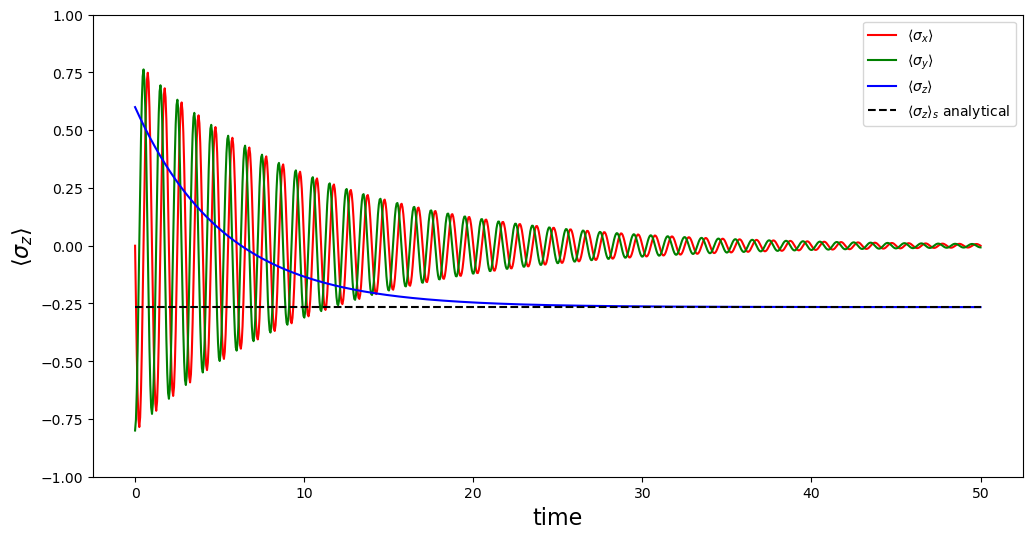

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(result1.times, result1.expect[0], "r",
        label=r"$\langle\sigma_x\rangle$")
ax.plot(result1.times, result1.expect[1], "g",
        label=r"$\langle\sigma_y\rangle$")
ax.plot(result1.times, result1.expect[2], "b",
        label=r"$\langle\sigma_z\rangle$")

sz_ss_analytical = -1 / (2 * N + 1)
ax.plot(
    result1.times,
    sz_ss_analytical * np.ones(len(result1.times)),
    "k--",
    label=r"$\langle\sigma_z\rangle_s$ analytical",
)


ax.set_ylabel(r"$\langle\sigma_z\rangle$", fontsize=16)
ax.set_xlabel("time", fontsize=16)
ax.legend()
ax.set_ylim(-1, 1);

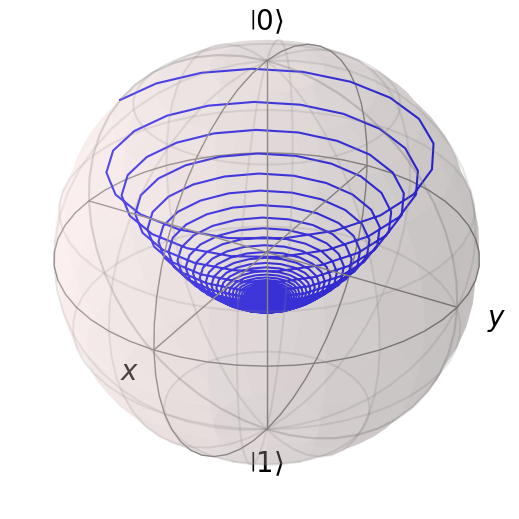

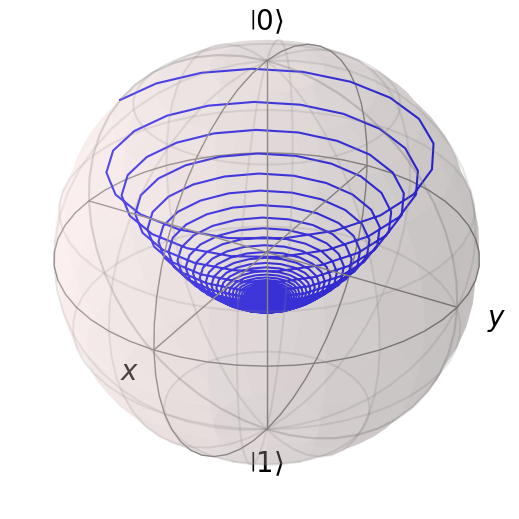

In [20]:
b = Bloch()
b.add_points(result1.expect, meth="l")
b.show()

### Alternative master equation on Lindblad form

We can solve the alternative master equation, which is on the standard Lindblad form, directly using the QuTiP `mesolve` function:

In [21]:
c_ops = [np.sqrt(gamma0) *
         (sm * np.cosh(r) + sp * np.sinh(r) * np.exp(1j * theta))]

In [22]:
result2 = mesolve(H, psi0, tlist, c_ops, e_ops=e_ops)

And we can verify that it indeed gives the same results:

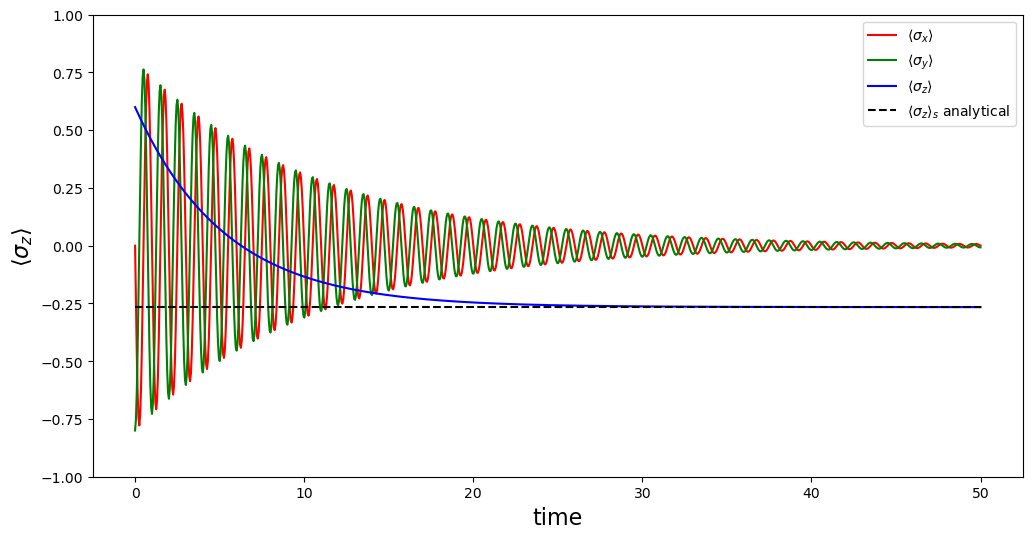

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(result2.times, result2.expect[0], "r",
        label=r"$\langle\sigma_x\rangle$")
ax.plot(result2.times, result2.expect[1], "g",
        label=r"$\langle\sigma_y\rangle$")
ax.plot(result2.times, result2.expect[2], "b",
        label=r"$\langle\sigma_z\rangle$")

sz_ss_analytical = -1 / (2 * N + 1)
ax.plot(
    result2.times,
    sz_ss_analytical * np.ones(len(result2.times)),
    "k--",
    label=r"$\langle\sigma_z\rangle_s$ analytical",
)


ax.set_ylabel(r"$\langle\sigma_z\rangle$", fontsize=16)
ax.set_xlabel("time", fontsize=16)
ax.legend()
ax.set_ylim(-1, 1);

### Compare the two forms of master equations

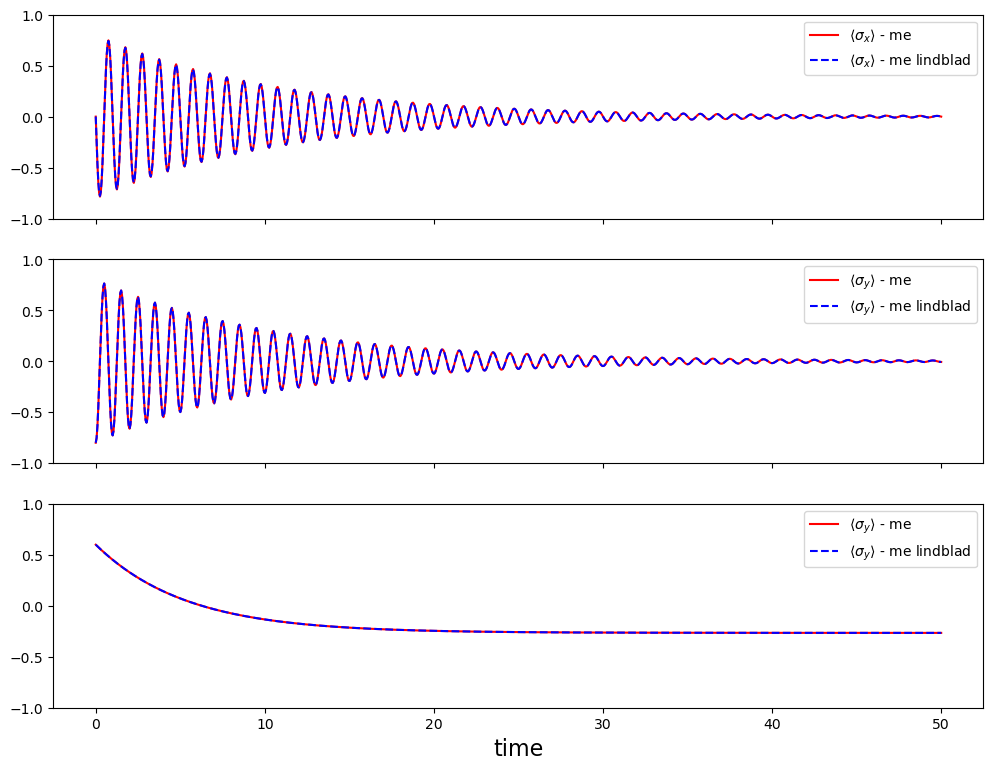

In [24]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 9))

axes[0].plot(
    result1.times, result1.expect[0], "r",
    label=r"$\langle\sigma_x\rangle$ - me"
)
axes[0].plot(
    result2.times,
    result2.expect[0],
    "b--",
    label=r"$\langle\sigma_x\rangle$ - me lindblad",
)
axes[0].legend()
axes[0].set_ylim(-1, 1)

axes[1].plot(
    result1.times, result1.expect[1], "r",
    label=r"$\langle\sigma_y\rangle$ - me"
)
axes[1].plot(
    result2.times,
    result2.expect[1],
    "b--",
    label=r"$\langle\sigma_y\rangle$ - me lindblad",
)
axes[1].legend()
axes[1].set_ylim(-1, 1)

axes[2].plot(
    result1.times, result1.expect[2], "r",
    label=r"$\langle\sigma_y\rangle$ - me"
)
axes[2].plot(
    result2.times,
    result2.expect[2],
    "b--",
    label=r"$\langle\sigma_y\rangle$ - me lindblad",
)
axes[2].legend()
axes[2].set_ylim(-1, 1)
axes[2].set_xlabel("time", fontsize=16);

### Compare dissipation into vacuum and squeezed vacuum

In [25]:
# for vacuum:
r = 0
theta = 0.0
c_ops = [np.sqrt(gamma0) *
         (sm * np.cosh(r) + sp * np.sinh(r) * np.exp(1j * theta))]

In [26]:
result1 = mesolve(H, psi0, tlist, c_ops, e_ops=e_ops)

In [27]:
# for squeezed vacuum:
r = 1.0
theta = 0.0
c_ops = [np.sqrt(gamma0) *
         (sm * np.cosh(r) + sp * np.sinh(r) * np.exp(1j * theta))]

In [28]:
result2 = mesolve(H, psi0, tlist, c_ops, e_ops=e_ops)

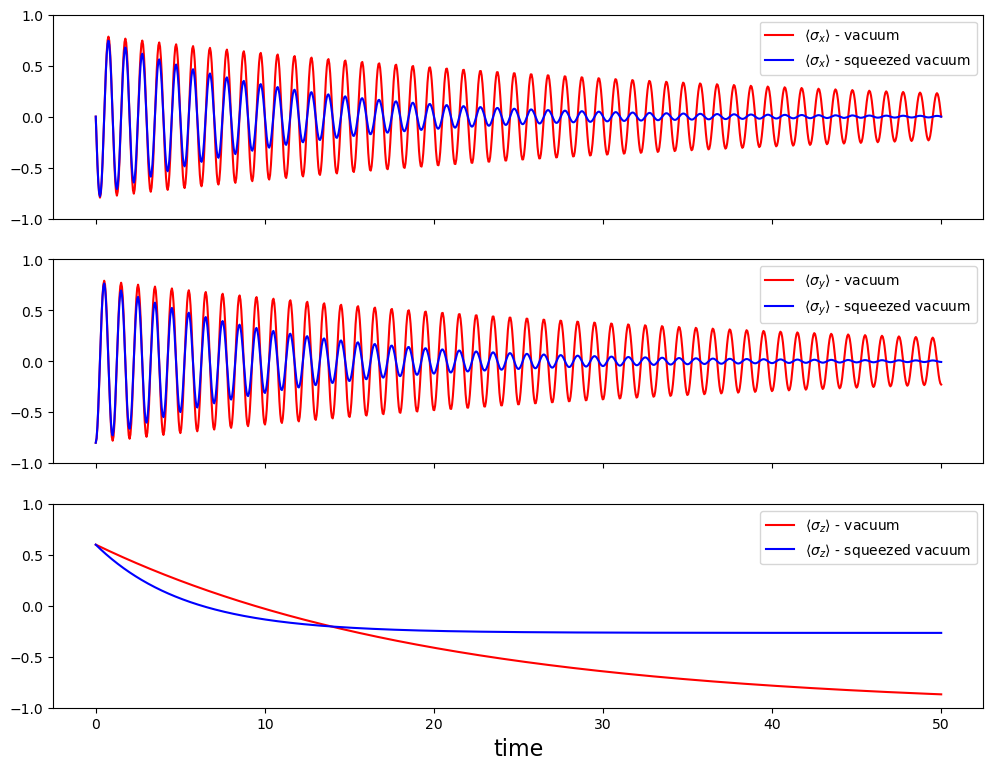

In [29]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 9))

axes[0].plot(
    result1.times, result1.expect[0], "r",
    label=r"$\langle\sigma_x\rangle$ - vacuum"
)
axes[0].plot(
    result2.times,
    result2.expect[0],
    "b",
    label=r"$\langle\sigma_x\rangle$ - squeezed vacuum",
)
axes[0].legend()
axes[0].set_ylim(-1, 1)

axes[1].plot(
    result1.times, result1.expect[1], "r",
    label=r"$\langle\sigma_y\rangle$ - vacuum"
)
axes[1].plot(
    result2.times,
    result2.expect[1],
    "b",
    label=r"$\langle\sigma_y\rangle$ - squeezed vacuum",
)
axes[1].legend()
axes[1].set_ylim(-1, 1)

axes[2].plot(
    result1.times, result1.expect[2], "r",
    label=r"$\langle\sigma_z\rangle$ - vacuum"
)
axes[2].plot(
    result2.times,
    result2.expect[2],
    "b",
    label=r"$\langle\sigma_z\rangle$ - squeezed vacuum",
)
axes[2].legend()
axes[2].set_ylim(-1, 1)
axes[2].set_xlabel("time", fontsize=16);

From this comparison it's clear that dissipation into a squeezed vacuum is faster than dissipation into vacuum.

### Software versions

In [30]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`
